In [1]:
import hyperSLIC
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
import time
import multiprocessing as mp
import numba as nb
from numba import jit
from tqdm import tqdm
import os
import copy
%matplotlib qt5

In [43]:
s = hs.load(r"D:\Dropbox (Cambridge University)\tas72@cam.ac.uk’s_files\Data_Backup\Halide_segregation\SED\Sample_3A_centered\20230822_104025.zspy",lazy=True)
#s = hs.load(r"E:\DLS_2022-5-31_15-19-31\dls\e02\data\2020\mg25142-9\processing\Merlin\mixed_halide_CHCL\20201214 174333\20201214_174333_correctionapplied_masked_centred.hspy",lazy=True)
#s = hs.load(r"C:\Users\tas72\Documents\PhD\synthetic_data\synthetic_data_circles.hspy", lazy=True)

In [45]:
s

<LazyElectronDiffraction2D, title: , dimensions: (512, 512|256, 256)>

In [11]:
s = s.rebin(scale=[1,1,2,2],dtype='same')

In [12]:
s = s.inav[:,:]
s.compute()

[########################################] | 100% Completed | 24.6s


In [13]:
s.plot()

In [15]:
s_copy = s.deepcopy()

In [5]:
constant = 15

In [6]:
s.isig[(s.axes_manager[2].size//2)-constant:(s.axes_manager[2].size//2)+constant,(s.axes_manager[3].size//2)-constant:(s.axes_manager[3].size//2)+constant] = 0#np.zeros((constant*2,constant*2))

In [16]:
@jit(nopython=True)
def normalise(channel):
    channel = (channel - np.amin(channel))+1 # breaks if value of 0 is given
    channel = channel/np.amax(channel)
    return channel


def plot_ranges(raveled,percentile,bins, mode, plot_or_not):
    reshaped = np.reshape(raveled, (np.shape(raveled)[0]*np.shape(raveled)[1], np.shape(raveled)[2]))
    if mode == 'range':
        ranges = np.ptp(reshaped, axis=0)
    if mode == 'var':
        ranges = np.var(reshaped,axis=0)
    percentile = np.percentile(ranges,percentile)
    print(percentile)
    if plot_or_not == True:
        fig,ax = plt.subplots()
        ax.hist(ranges,density = True, bins = bins)
        plt.yscale('log')

        ax.axvline(percentile,linestyle = ":",color ='r' )

@jit(nopython = True)
def quick_wheat(ranges, reshaped, percentile):
    wheat = reshaped.T[ranges >= percentile]
    return wheat.T

def wheat_from_chaff(data, percentile,mode):
    reshaped = np.reshape(data, (np.shape(data)[0]*np.shape(data)[1], np.shape(data)[2]))
    print(np.shape(reshaped))
    print('Reshaped')
    if mode == 'range':
        ranges = np.ptp(reshaped, axis=0)
    if mode == 'var':
        ranges = np.var(reshaped,axis=0)
    ranges = np.ptp(reshaped, axis=0)
    print(np.shape(ranges))
    print('Ranges aquried')
    percentile = np.percentile(ranges,percentile)
    print(percentile)
    wheat = quick_wheat(ranges, reshaped, percentile)
    print(np.shape(wheat))
    print('Wheat separated')
    maxes = np.amax(wheat, axis=0)
    minis = np.amin(wheat,axis=0) 
    
    wheat = wheat - minis

    wheat = wheat/maxes
    
    wheat = np.reshape(wheat,(np.shape(data)[0],np.shape(data)[1],-1))
    return wheat

In [17]:
raveled = np.reshape(s.data, (s.axes_manager[1].size, s.axes_manager[0].size,s.axes_manager[2].size*s.axes_manager[3].size))

In [18]:
plot_ranges(raveled,95,50,'range',False)

252.0


In [19]:
wheat = wheat_from_chaff(raveled,98,'range')
print('Complete', np.shape(wheat))

(262144, 16384)
Reshaped
(16384,)
Ranges aquried
252.0
(262144, 2106)
Wheat separated
Complete (512, 512, 2106)


In [20]:
wheat_hs = hs.signals.Signal1D(wheat)

In [21]:
wheat_hs.T.plot()

In [40]:
test = hyperSLIC.SLIC(wheat_hs,'regular',1000,2,1) # seed_num, m, searchspace

In [41]:
test

In [42]:
summed = s.T.sum().data
t0 = time.time()
for i in tqdm(range(10)):
    
    
    test.find_closest_centeroid()
   
   
    test.update_centeroids()
    
t1 = time.time()
print(f'Time: {np.round((t1-t0),3)}s')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:19<00:00, 13.98s/it]

Time: 139.778s


In [34]:
cmap = plt.cm.colors.ListedColormap(plt.cm.gist_stern(vals))
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
centeroids = np.zeros((test.width,test.height))
for counter,centeroid in enumerate(test.xy_centeroids):
    centeroids[int(centeroid[0]),int(centeroid[1])] = counter    
fig,ax = plt.subplots()
ax.imshow(centeroids,cmap=cmap)

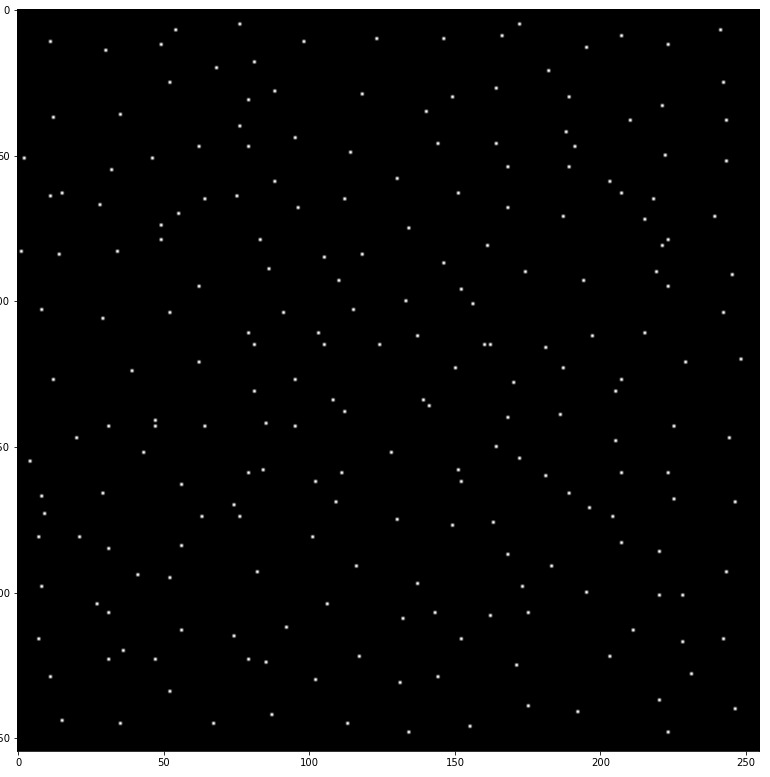

In [35]:
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.gist_stern(vals))

fig,ax = plt.subplots(1,3)
ax[0].imshow(summed,cmap='gray')
ax[1].imshow(test.closest_centeroid,cmap=cmap)
ax[2].imshow(summed,cmap='gray')
ax[2].imshow(test.closest_centeroid,cmap=cmap,alpha=0.25)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
#plt.savefig('dark_feild_total',dpi=600)

[]

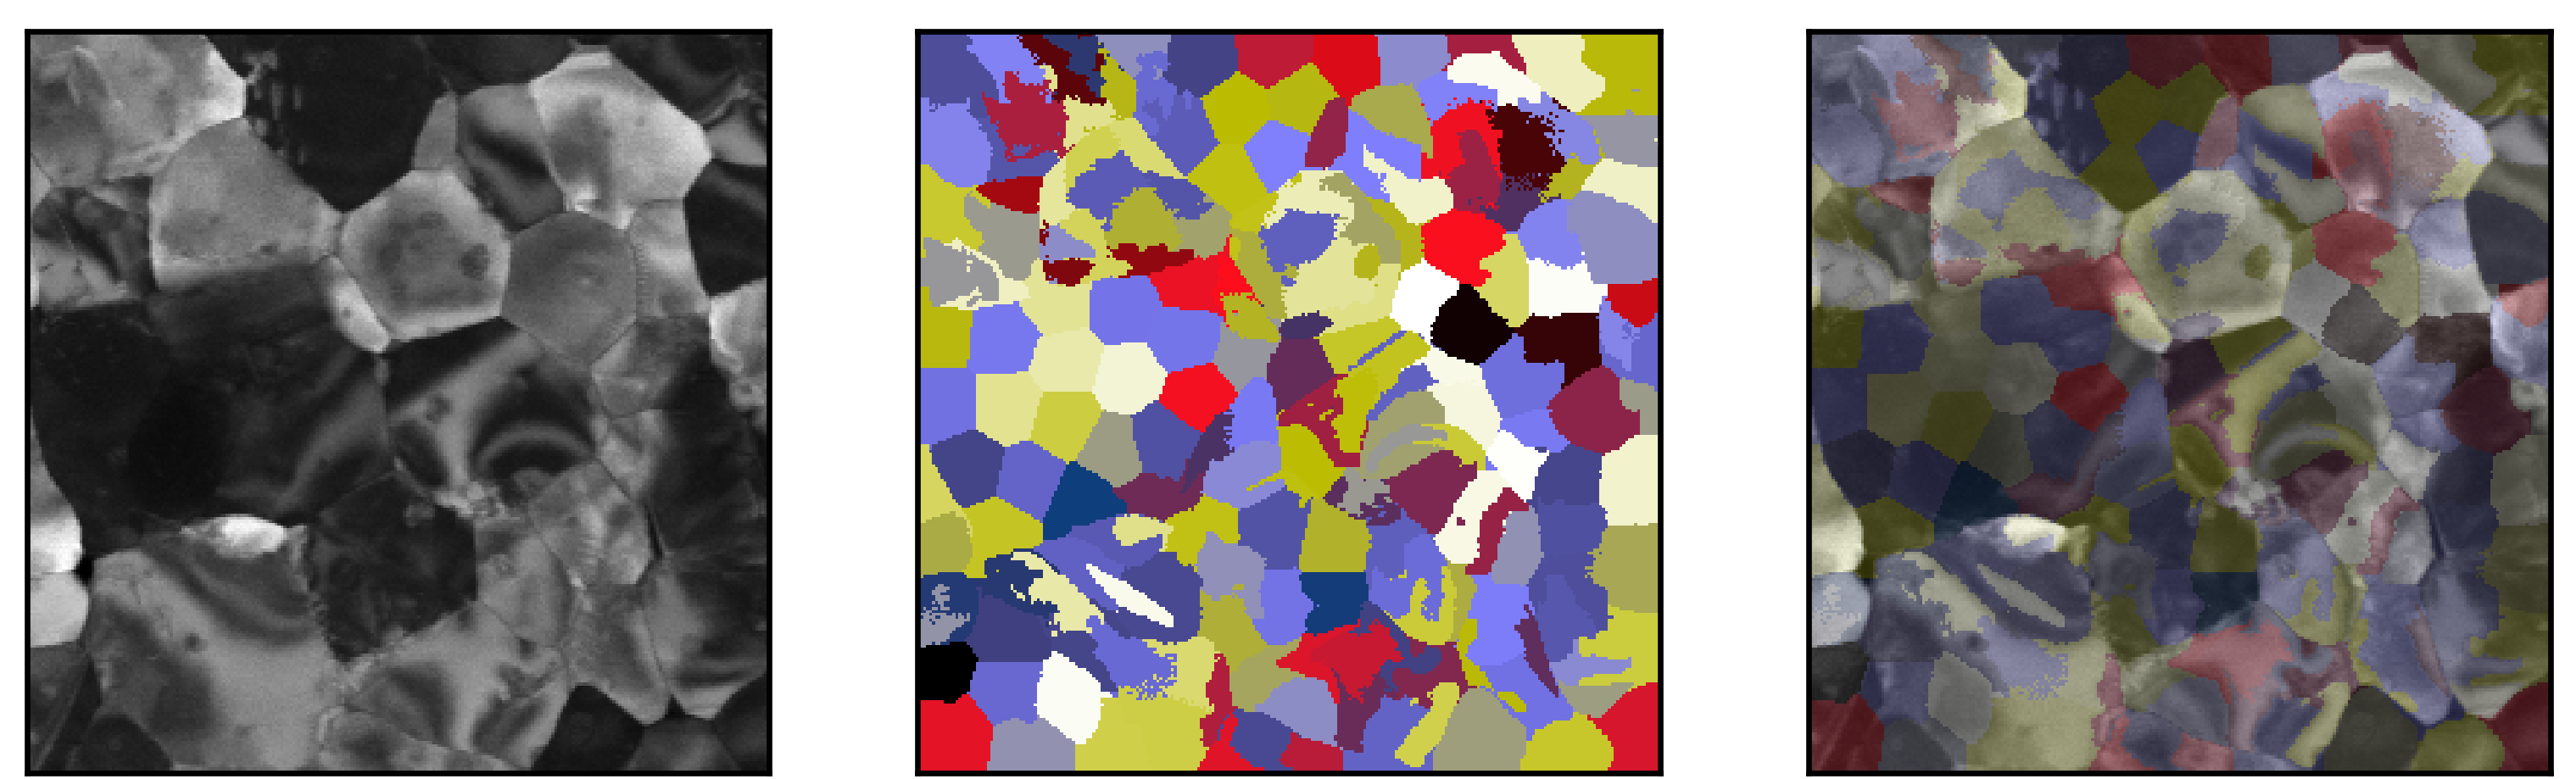

Check if regions are similar to eachother- and merge is this is so

In [36]:
summed_channels = np.zeros(test.k,dtype='object')
number_of_occurances = np.zeros(test.k)

for row in tqdm(range(np.shape(test.closest_centeroid)[0])):
    for col in range(np.shape(test.closest_centeroid)[1]):
        
        arg = int(test.closest_centeroid[row,col])
        number_of_occurances[arg] += 1 
        channel = test.dot_data[row,col].astype(np.float32)# Use the copy not the data with the masked bright feild
        summed_channels[arg]+=channel

for i in range(len(number_of_occurances)):
    occurances = number_of_occurances[i]
    if occurances == 0:
        number_of_occurances[i] = np.nan
        

mean_channels = summed_channels/number_of_occurances

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [00:07<00:00, 65.88it/s]


In [39]:
from scipy.stats.stats import pearsonr
updated_centroids = copy.deepcopy(test.closest_centeroid)
for i in tqdm(range(len(mean_channels))):
    channel_oi = mean_channels[i]
    for counter,comparison_channel in enumerate(mean_channels[i:]):
        difference = channel_oi - comparison_channel
        difference = np.abs(difference)
        difference = np.sum(difference)
        try:
            r = pearsonr(channel_oi,comparison_channel)
            if r[0] > 0.99:
                args = np.where(updated_centroids == i)
                for j in range(len(args[0])):
                        row = args[0][j]
                        col = args[1][j]
                        updated_centroids[row,col] = i+counter
        except:
            pass
                
fig,ax = plt.subplots(1,3)
ax[0].imshow(summed,cmap='gray')
ax[1].imshow(test.closest_centeroid,cmap=cmap)
ax[2].imshow(updated_centroids,cmap=cmap)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.59it/s]


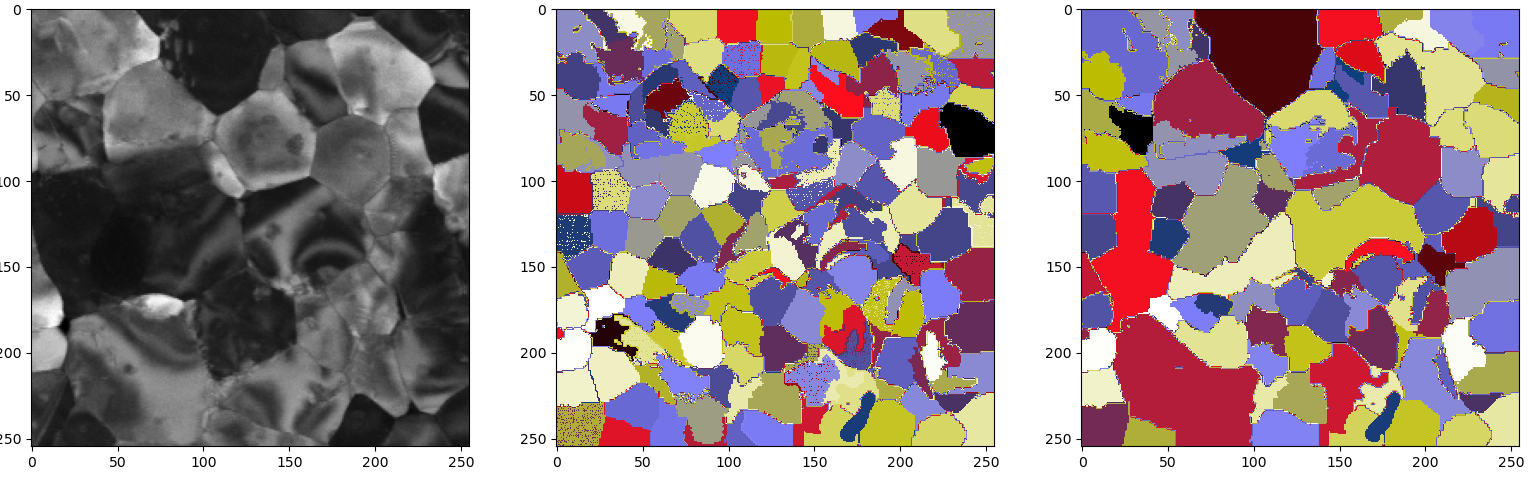

In [32]:
summed_patterns = np.zeros(test.k,dtype='object')

number_of_occurances = np.zeros(test.k)


for row in tqdm(range(np.shape(test.closest_centeroid)[0])):
    for col in range(np.shape(test.closest_centeroid)[1]):
        
        arg = int(test.closest_centeroid[row,col])
        number_of_occurances[arg] += 1 
        pattern = s_copy.data[row,col].astype(np.float32)# Use the copy not the data with the masked bright feild
        summed_patterns[arg]+=pattern

for i in range(len(number_of_occurances)):
    occurances = number_of_occurances[i]
    if occurances == 0:
        number_of_occurances[i] = -1
        

mean_patterns = summed_patterns/number_of_occurances

100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [01:08<00:00,  3.75it/s]


In [33]:
fig,ax = plt.subplots(10,25)
for i in range(10):
    for j in range(25):
        try:
            ax[i,j].imshow(mean_patterns[i*25+j],vmax=0.1,cmap='Greys')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            #ax[i,j].title.set_text(i*25+j)

        except:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

plt.tight_layout()
plt.subplots_adjust(left=0, right=1, top=1, bottom=0,wspace=-0, hspace=0)
#plt.savefig('all_patterns.png', dpi=300)

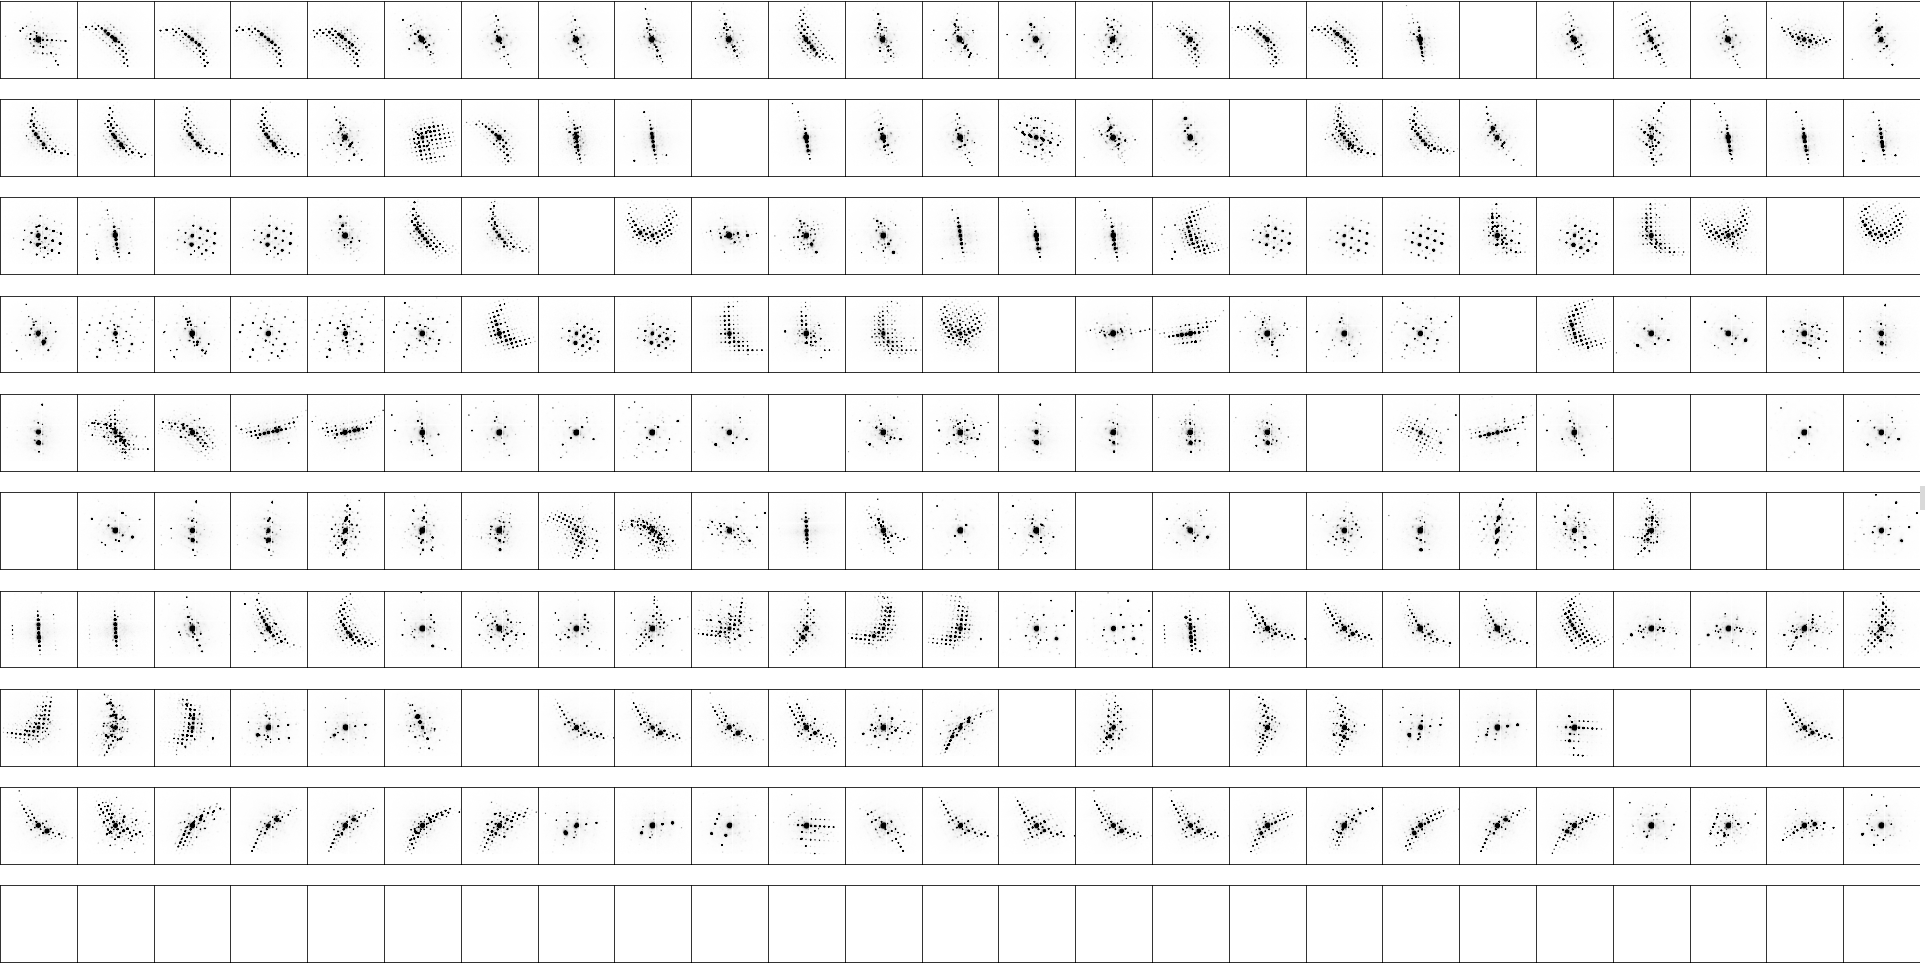

In [116]:
fig,ax = plt.subplots()
ax.imshow(summed_patterns[217],cmap = 'Greys',vmax=30)
ax.set_xticks([])
ax.set_yticks([])
plt.waitforbuttonpress()                
plt.close()

In [67]:
np.save('diffrcation_patterns',mean_patterns)

In [68]:
np.save('clusters',test.closest_centeroid)

In [ ]:
np.load()